# Model Performance Reporting Notebook

This notebook generates comprehensive evaluation reports for each AI-based evaluator model. It reads the `*_evaluations.csv` files produced by the `5_Evaluation.ipynb` pipeline, computes summary statistics, inter-rater reliability metrics (Cohen's Kappa), component-specific distance averages, and domain-specific distance averages, and writes a neatly formatted Markdown report for each model into the `model_reports/` directory.

**Notebook Structure**:
1. Imports and Setup
2. Directory Configuration
3. Helper Functions
4. Load Framework & Human Evaluations
5. Report Generation Function
6. Execute Report Generation
7. Reliability Exam Functions
8. Reliability Exam Visualizations
9. Execute Reliability Exams and Generate Visualizations

_Note: Make sure you have run `5_Evaluation.ipynb` and that the `model_evaluation_data/` folder contains your `*_evaluations.csv` files, and that you have access to your human evaluation data (`peru_cleaned_transcripts.csv`) and framework JSON (`Teach_1.json`)._

In [12]:
# 1. Imports and Setup
import os
import glob
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import cohen_kappa_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Define a blue color palette
COLOR_PALETTE = ['#1f77b4']


## 2. Directory Configuration

Define paths for input evaluation CSVs and output reports, and ensure the output directory exists.

In [13]:
# Directories
import sys
import os
from pathlib import Path

sys.path.append('/Users/mkrasnow/Desktop/montesa')

EVALS_DIR = 'model_evaluation_data'
REPORTS_DIR = 'model_reports'
VIZ_DIR = 'model_visualizations'
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)
print(f"Input evaluations directory: {EVALS_DIR}")
print(f"Output reports directory:    {REPORTS_DIR}")
print(f"Visualizations directory:    {VIZ_DIR}")

Input evaluations directory: model_evaluation_data
Output reports directory:    model_reports
Visualizations directory:    model_visualizations


## 3. Helper Functions

Define utility functions for converting labels to numeric, computing normalized distances, and computing Cohen's Kappa.

In [14]:
def alpha_to_numeric(x):
    """
    Convert string labels to numeric values:
      - 'Y'/'y'/'Yes'/'1' -> 1.0
      - 'N'/'n'/'No'/'0'  -> 0.0
      - 'N/A' or empty   -> np.nan
      - 'L' -> 1.0, 'M' -> 2.0, 'H' -> 3.0
      - Numeric strings convertible to float -> float(x)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s in {'Y','y','Yes','1'}:
        return 1.0
    if s in {'N','n','No','0'}:
        return 0.0
    if s in {'N/A','','NA','na','nan'}:
        return np.nan
    if s in {'L','M','H'}:
        return {'L':1.0,'M':2.0,'H':3.0}[s]
    try:
        return float(s)
    except ValueError:
        return np.nan

def component_distance(human_score, ai_score, score_type):
    """
    Compute normalized distance between human and AI scores.
    score_type: 'YN' (max 1), 'LMH' (max 2), 'NUM' (1-5 scale, max diff 4).
    Returns float in [0,1].
    """
    h = alpha_to_numeric(human_score)
    a = alpha_to_numeric(ai_score)
    if math.isnan(h) and math.isnan(a):
        return 0.0
    if math.isnan(h) ^ math.isnan(a):
        return 1.0
    if score_type == 'YN':
        dmax = 1.0
    elif score_type == 'LMH':
        dmax = 2.0
    else:
        dmax = 4.0
    return min(max(abs(h - a) / dmax, 0.0), 1.0)

def encode_for_kappa(series, score_list):
    """Map categorical labels to integers for Cohen's Kappa."""
    mapping = {str(lbl): i for i, lbl in enumerate(score_list)}
    na_idx = mapping.get('N/A')
    def map_val(x):
        x_str = str(x)
        if x_str in mapping:
            return mapping[x_str]
        return na_idx if na_idx is not None else np.nan
    return series.map(map_val)

def compute_component_kappa(human_series, ai_series, score_list, weight=None):
    """Compute Cohen's Kappa for a single component."""
    h_enc = encode_for_kappa(human_series, score_list)
    a_enc = encode_for_kappa(ai_series, score_list)
    mask = ~(h_enc.isna() | a_enc.isna())
    if mask.sum() == 0:
        return np.nan
    if weight is None:
        numeric_labels = all(str(lbl).isdigit() for lbl in score_list) and len(score_list) > 2
        if any(lbl in ['L','M','H'] for lbl in score_list) or numeric_labels:
            weight = 'quadratic'
    return cohen_kappa_score(h_enc[mask], a_enc[mask], weights=weight)

def compute_distances_for_item(human_row, ai_row, framework):
    """
    Compute domain-level and overall normalized distances for one item.
    Returns (domain_distances: dict(domain_id->float), overall_distance:float).
    """
    domain_dist = {}
    num = 0.0
    wsum = 0.0
    for domain in framework['structure']['domains']:
        did = str(domain['id'])
        dnum = 0.0
        dwsum = 0.0
        stype = 'NUM'
        for comp in domain['components']:
            cname = comp['name']
            cweight = float(comp.get('weight',1.0))
            sl = comp.get('scoreList', [])
            if set(sl) <= {'Y','N','N/A'}:
                stype = 'YN'
            elif set(sl) <= {'L','M','H','N/A'}:
                stype = 'LMH'
            d = component_distance(human_row.get(cname), ai_row.get(cname), stype)
            dnum += cweight * d
            dwsum += cweight
        Dd = (dnum / dwsum) if dwsum>0 else 0.0
        domain_dist[did] = Dd
        num += float(domain.get('weight',1.0)) * Dd
        wsum += float(domain.get('weight',1.0))
    overall = (num/wsum) if wsum>0 else 0.0
    return domain_dist, overall

## 4. Load Framework & Human Evaluations

Functions to load the evaluation framework JSON and the cleaned transcripts with human evaluation scores.

In [15]:
from pathlib import Path

def load_framework(path):
    with open(path, 'r') as f:
        return json.load(f)

def load_human_evaluations(cleaned_csv_path, framework_json_path):
    df = pd.read_csv(cleaned_csv_path, dtype=str)
    # Extract base_id and clip_number
    clip_info = df['School_Clip'].str.extract(r'(?P<base_id>\d{6,7})\s*Clip\s*(?P<clip_num>[12])')
    df['base_id'] = clip_info['base_id']
    df['clip_number'] = clip_info['clip_num'].map({'1':'first','2':'last'})
    # Determine evaluation columns from framework
    framework = load_framework(framework_json_path)
    eval_cols = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            if comp['name'] in df.columns:
                eval_cols.append(comp['name'])
    return df[['base_id','clip_number'] + eval_cols]

# Example paths (adjust as needed)
FRAMEWORK_PATH   = '/Users/mkrasnow/Desktop/montesa/new/models/_context/high_Teach_1.json'
TRANSCRIPTS_PATH = '/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv'

## 5. Report Generation Function

This function iterates over each `*_evaluations.csv` file, computes all metrics, and writes a Markdown report for each model.

In [16]:
def generate_reports(framework_path, transcripts_path, evals_dir, reports_dir):
    framework = load_framework(framework_path)
    human_df  = load_human_evaluations(transcripts_path, framework_path)

    # Gather component definitions
    components = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            components.append({
                'id': str(comp['id']),
                'name': comp['name'],
                'score_list': comp.get('scoreList', ['Y','N','N/A'])
            })

    # Process each evaluation CSV
    for eval_file in glob.glob(os.path.join(evals_dir, '*_evaluations.csv')):
        model_name = os.path.basename(eval_file).replace('_evaluations.csv','')
        ai_df = pd.read_csv(eval_file, dtype=str)

        FILTER_MIN15_ONLY = True
        MIN15_CSV_PATH    = '/Users/mkrasnow/Desktop/montesa/new/formattedData/MIN15_TIMESTAMPED_peru_cleaned_transcripts.csv'

        if FILTER_MIN15_ONLY:
            # 1. Read the list of long clips (already in "123456 Clip 1"/"123456 Clip 2" format)
            min15_df    = pd.read_csv(MIN15_CSV_PATH, dtype=str)
            min15_clips = set(min15_df['School_Clip'].unique())

            # 2. Ensure both DataFrames have a School_Clip column
            def make_clip_label(row):
                num = '1' if row['clip_number'] == 'first' else '2'
                return f"{row['base_id']} Clip {num}"

            for df in (human_df, ai_df):
                if 'School_Clip' not in df.columns:
                    df['School_Clip'] = df.apply(make_clip_label, axis=1)

            # 3. Filter to only those long clips
            pre_h, pre_a = len(human_df), len(ai_df)
            human_df = human_df[human_df['School_Clip'].isin(min15_clips)].reset_index(drop=True)
            ai_df    = ai_df   [ai_df   ['School_Clip'].isin(min15_clips)].reset_index(drop=True)

            print(f"🔍 Filtered ≥15 min clips: human {pre_h}→{len(human_df)} rows; AI {pre_a}→{len(ai_df)} rows")

        # Compute distances for each item and track agreement
        dist_records = []
        for _, row in ai_df.iterrows():
            hr = human_df[(human_df.base_id==row.base_id)&(human_df.clip_number==row.clip_number)]
            if hr.empty: continue
            hr = hr.iloc[0]
            dom_dist, overall = compute_distances_for_item(hr, row, framework)
            rec = {'base_id':row.base_id,'clip_number':row.clip_number,'overall_distance':overall}
            for did, dval in dom_dist.items(): rec[f'domain_{did}_dist'] = dval
            dist_records.append(rec)
        distances_df = pd.DataFrame(dist_records)
        # Add LLM-human agreement column (accuracy) as 1 - distance
        if distances_df.empty:
            print(f"❌ No distances computed for {model_name}")
            continue
        distances_df['agreement'] = 1 - distances_df['overall_distance']

        # Summary statistics for distance and agreement
        overall_stats = distances_df['overall_distance'].describe()
        agreement_stats = distances_df['agreement'].describe()

        # Component-wise Cohen's Kappa
        kappa_records = []
        for comp in components:
            comp_name = comp['name']
            # Skip if component not present in either AI or human evaluations
            if comp_name not in ai_df.columns or comp_name not in human_df.columns:
                continue
            h_ser = human_df[comp_name]
            a_ser = ai_df[comp_name]
            numeric_labels = all(str(lbl).isdigit() for lbl in comp['score_list']) and len(comp['score_list']) > 2
            weight = 'quadratic' if any(lbl in ['L','M','H'] for lbl in comp['score_list']) or numeric_labels else None
            try:
                k = compute_component_kappa(h_ser, a_ser, comp['score_list'], weight)
            except:
                k = np.nan
            kappa_records.append({'component_name': comp_name, 'kappa': k})
        kappa_df = pd.DataFrame(kappa_records)

        # Component-specific distance averages
        comp_dist_avgs = []
        for comp in components:
            cname = comp['name']
            # Skip if component not present in either AI or human evaluations
            if cname not in ai_df.columns or cname not in human_df.columns:
                continue
            # Compute mean normalized diff per component
            diffs = ai_df.apply(lambda r: component_distance(
                human_df[(human_df.base_id == r.base_id) & (human_df.clip_number == r.clip_number)].iloc[0].get(cname),
                r.get(cname),
                'YN' if set(comp['score_list']) <= {'Y', 'N', 'N/A'} else ('LMH' if set(comp['score_list']) <= {'L', 'M', 'H', 'N/A'} else 'NUM')
            ), axis=1)
            comp_dist_avgs.append({'component_name': cname, 'avg_distance': diffs.mean()})
        comp_dists_df = pd.DataFrame(comp_dist_avgs)

        # Domain-specific distance averages
        domain_avgs = []
        for domain in framework['structure']['domains']:
            did = str(domain['id'])
            col = f'domain_{did}_dist'
            if col in distances_df.columns:
                domain_avgs.append({'domain_id':did,'domain_name':domain['name'],'avg_distance':distances_df[col].mean()})
        domain_dists_df = pd.DataFrame(domain_avgs)

        # Build Markdown report
        lines = []
        lines.append(f"# Report for Model: **{model_name}**\n")
        lines.append("## 1. Distance and LLM-Human Agreement Summary Statistics\n")
        lines.append("### 1.1 Overall Distance\n")
        lines.append(overall_stats.to_markdown() + "\n")
        lines.append("### 1.2 LLM-Human Agreement\n")
        lines.append(agreement_stats.to_markdown() + "\n")
        lines.append("## 2. Inter-Rater Reliability (Cohen's Kappa)\n")
        lines.append(kappa_df.to_markdown(index=False) + "\n")
        lines.append("## 3. Component-Specific Distance Averages\n")
        lines.append(comp_dists_df.to_markdown(index=False) + "\n")
        lines.append("## 4. Domain-Specific Distance Averages\n")
        lines.append(domain_dists_df.to_markdown(index=False) + "\n")

        report_md = "\n".join(lines)
        out_path = os.path.join(reports_dir, f"{model_name}_report.md")
        with open(out_path, 'w') as f:
            f.write(report_md)
        print(f"✅ Written report for {model_name} → {out_path}")

## 6. Execute Report Generation

Run the `generate_reports` function with your configured paths.

In [17]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [18]:
generate_reports(
    framework_path=FRAMEWORK_PATH,
    transcripts_path=TRANSCRIPTS_PATH,
    evals_dir=EVALS_DIR,
    reports_dir=REPORTS_DIR,
)

print("\nAll model reports generated successfully.")

🔍 Filtered ≥15 min clips: human 199→71 rows; AI 84→31 rows
✅ Written report for 0-TEST-Control → model_reports/0-TEST-Control_report.md
🔍 Filtered ≥15 min clips: human 71→71 rows; AI 84→31 rows
✅ Written report for 5-TEST-High-Rubric-Timestamped → model_reports/5-TEST-High-Rubric-Timestamped_report.md
🔍 Filtered ≥15 min clips: human 71→71 rows; AI 84→31 rows
✅ Written report for 2-TEST-Medium-Rubric → model_reports/2-TEST-Medium-Rubric_report.md
🔍 Filtered ≥15 min clips: human 71→71 rows; AI 84→31 rows
✅ Written report for 3-TEST-High-Rubric → model_reports/3-TEST-High-Rubric_report.md
🔍 Filtered ≥15 min clips: human 71→71 rows; AI 84→31 rows
✅ Written report for 4-TEST-High-Rubric-Reasoning → model_reports/4-TEST-High-Rubric-Reasoning_report.md
🔍 Filtered ≥15 min clips: human 71→71 rows; AI 84→31 rows
✅ Written report for 1-TEST-BaseEvaluator → model_reports/1-TEST-BaseEvaluator_report.md

All model reports generated successfully.


## 7. Reliability Exam Functions

Evaluate AI models against the Teach Reliability Exam criteria:
- **Time on Learning**: exact agreement on 2 of 3 snapshots per segment.
- **Quality Elements**: within 1 point of master codes on at least 8 of 10 high-inference elements per segment.

Two evaluation versions are implemented:
1. **Random Set Exam**: Two attempts with random sets of three segments.
2. **Average Exam**: Compute exam metrics across all available segments.

In [19]:
# Reliability Exam Functions
import random
import math

# --- Column definitions ----------------------------------------------------
snapshot_teacher = [
    'Teacher provides learning activity - 1st Snapshot',
    'Teacher provides learning activity - 2nd Snapshot',
    'Teacher provides learning activity - 3rd Snapshot'
]
snapshot_students = [
    'Students are on task - 1st Snapshot',
    'Students are on task - 2nd Snapshot',
    'Students are on task - 3rd Snapshot'
]
quality_elements = [
    'Supportive Learning Environment',
    'Positive Behavioral Expectations',
    'Lesson Facilitation',
    'Checks for understanding',
    'Feedback',
    'Critical Thinking',
    'Autonomy',
    'Perseverance',
    'Social & Collaborative Skills'
]

# --- Core helpers ----------------------------------------------------------
def _lookup_human_row(ai_row, human_df):
    """Return the matching human-coded row or None."""
    h_rows = human_df[
        (human_df['base_id'] == ai_row['base_id']) &
        (human_df['clip_number'] == ai_row['clip_number'])
    ]
    return None if h_rows.empty else h_rows.iloc[0]

def evaluate_segment(ai_row, human_row):
    """True ⇢ segment reliable on ≥ 8 / 10 elements (TEACH definition)."""
    teacher_ok = sum(
        alpha_to_numeric(human_row[c]) == alpha_to_numeric(ai_row[c])
        for c in snapshot_teacher
    ) >= 2

    quality_ok = [
        False if (
            math.isnan(alpha_to_numeric(human_row[col])) or
            math.isnan(alpha_to_numeric(ai_row[col]))
        ) else abs(alpha_to_numeric(human_row[col]) -
                   alpha_to_numeric(ai_row[col])) <= 1
        for col in quality_elements
    ]

    return (1 if teacher_ok else 0) + sum(quality_ok) >= 8

# --- Monte-Carlo simulators -------------------------------------------------
def run_monte_carlo(models, ai_df, human_df, *, set_size=3,
                    seed=42, n_simulations=1000):
    """Legacy helper kept for backward compatibility."""
    return run_random_exam(models, ai_df, human_df, attempts=1,
                           set_size=set_size, seed=seed,
                           n_simulations=n_simulations)

def run_random_exam(models, ai_df, human_df, *, attempts=2, set_size=3,
                    seed=42, n_simulations=1000):
    """
    Monte-Carlo implementation of the TEACH certification exam:

    • For each simulation draw ≤ `attempts` sets of `set_size` segments.  
    • A simulation is a *success* if any attempt passes all segments.  
    • Returns a dict keyed by model containing success/failure counts,
      pass_probability, and a boolean `certified` flag
      (≥ 80 % success probability by default).
    """
    random.seed(seed)
    results = {m: {'successes': 0, 'failures': 0, 'total': n_simulations}
               for m in models}

    # Cache (base_id, clip_number) keys that exist in both AI & human sets
    key_cache = {}
    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]
        key_cache[model] = [
            (row.base_id, row.clip_number)
            for row in df_m[['base_id', 'clip_number']].drop_duplicates().itertuples(index=False)
            if not human_df[
                (human_df['base_id'] == row.base_id) &
                (human_df['clip_number'] == row.clip_number)
            ].empty
        ]

    # Main simulation loop
    for model in models:
        keys = key_cache[model]
        for _ in range(n_simulations):
            if len(keys) < set_size:                       # not enough data
                results[model]['failures'] += 1
                continue

            passed_exam = False
            used_keys = set()
            for _attempt in range(attempts):
                remaining = [k for k in keys if k not in used_keys]
                if len(remaining) < set_size:
                    break                                  # not enough fresh segments
                sample = random.sample(remaining, k=set_size)
                used_keys.update(sample)

                # Evaluate this attempt
                attempt_ok = True
                for base_id, clip_num in sample:
                    ai_row = ai_df[
                        (ai_df['base_id']   == base_id) &
                        (ai_df['clip_number'] == clip_num) &
                        (ai_df['model_name'] == model)
                    ].iloc[0]
                    human_row = _lookup_human_row(ai_row, human_df)
                    if human_row is None or not evaluate_segment(ai_row, human_row):
                        attempt_ok = False
                        break
                if attempt_ok:
                    passed_exam = True
                    break                                   # stop further attempts

            if passed_exam:
                results[model]['successes'] += 1
            else:
                results[model]['failures']  += 1

    # Convenience metrics
    for model in models:
        r = results[model]
        r['pass_probability'] = r['successes'] / r['total']
        r['certified']        = r['pass_probability'] >= 0.80  # 80 % threshold

    return results

# --- Average-Exam (full-dataset) -------------------------------------------------
def run_average_exam(models, ai_df, human_df):
    """
    Compute exam metrics across all available segments (no sampling).
    Returns for each model:
      - pass_rate: fraction of segments passing the ≥8/10 rule
      - component_performance:
          - time_on_learning.reliability_rate: 2/3 snapshot matches rate
          - quality_teaching_practices.average_reliability_rate: avg(≤1-point) rate
    """
    results = {}
    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]
        # only segments with human reference
        keys = [
            (row.base_id, row.clip_number)
            for row in df_m[['base_id','clip_number']].drop_duplicates().itertuples(index=False)
            if not human_df[
                (human_df['base_id'] == row.base_id) &
                (human_df['clip_number'] == row.clip_number)
            ].empty
        ]
        total = len(keys)
        pass_count = 0
        tol_count = 0
        qtp_rates = []

        for base_id, clip_num in keys:
            ai_row = df_m[
                (df_m['base_id']==base_id) &
                (df_m['clip_number']==clip_num)
            ].iloc[0]
            human_row = _lookup_human_row(ai_row, human_df)

            # Time-on-Learning reliability
            teacher_matches = sum(
                alpha_to_numeric(human_row[c]) == alpha_to_numeric(ai_row[c])
                for c in snapshot_teacher
            ) >= 2
            tol_count += int(teacher_matches)

            # Quality Teaching Practices reliability per segment
            quality_ok = [
                False if (
                    math.isnan(alpha_to_numeric(human_row[col])) or
                    math.isnan(alpha_to_numeric(ai_row[col]))
                ) else abs(alpha_to_numeric(human_row[col]) -
                           alpha_to_numeric(ai_row[col])) <= 1
                for col in quality_elements
            ]
            qtp_rates.append(sum(quality_ok) / len(quality_elements))

            # Overall segment pass?
            if evaluate_segment(ai_row, human_row):
                pass_count += 1

        pass_rate = pass_count / total if total > 0 else 0.0
        tol_rate  = tol_count  / total if total  > 0 else 0.0
        qtp_avg   = sum(qtp_rates) / len(qtp_rates) if qtp_rates else 0.0

        results[model] = {
            'pass_rate': pass_rate,
            'component_performance': {
                'time_on_learning': {
                    'reliability_rate': tol_rate
                },
                'quality_teaching_practices': {
                    'average_reliability_rate': qtp_avg
                }
            }
        }

    return results


## 8. Reliability Exam Visualizations

Create comprehensive visualizations for reliability exam results that are robust to handle any number of models.

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Mapping from internal model IDs (as derived from filenames) to user-facing names,
# in the exact left-to-right display order you want.
MODEL_NAME_MAPPING = {
    '0-TEST-Control':                  'Control',
    '1-TEST-BaseEvaluator':            'Base',
    '2-TEST-Medium-Rubric':            'Medium Rubric',
    '3-TEST-High-Rubric':              'High Rubric',
    '4-TEST-High-Rubric-Reasoning':    'High Rubric + Reasoning',
    '5-TEST-High-Rubric-Timestamped':  'High Rubric + Timestamps'
}

def create_monte_carlo_pie_charts(mc_results, save_path=None):
    """
    Create a separate pie-chart figure with one subplot per model,
    showing Monte Carlo success vs. failure rates, using user-facing names.
    """
    internal_models = [key for key in MODEL_NAME_MAPPING if key in mc_results]
    n = len(internal_models)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for ax, internal in zip(np.atleast_1d(axes), internal_models):
        res = mc_results[internal]
        display_name = MODEL_NAME_MAPPING[internal]
        labels = ['Successes', 'Failures']
        counts = [res['successes'], res['failures']]
        ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'{display_name}\n({res["successes"]}/{res["total"]} passes)')

    plt.suptitle('Monte Carlo Certification Results', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

def create_exam_performance_dashboard(avg_results, save_path=None):
    """
    Dashboard showing overall segment pass rate (>=8/10 elements),
    using user-facing model names in the desired order.
    """
    internal_models = [key for key in MODEL_NAME_MAPPING if key in avg_results]
    display_names    = [MODEL_NAME_MAPPING[key] for key in internal_models]
    pass_rates       = [avg_results[key]['pass_rate'] * 100 for key in internal_models]
    n = len(internal_models)

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(n)
    bars = ax.bar(
        x,
        pass_rates,
        width=0.6,
        color=COLOR_PALETTE[0],
        edgecolor='black',
        linewidth=0.5
    )
    ax.axhline(80, linestyle='--', linewidth=2, label='Segment Pass Threshold (80%)')
    ax.set_xticks(x)
    ax.set_xticklabels(display_names, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Pass Rate (%)', fontsize=12)
    ax.set_title('Average Segment Pass Rate by Model', fontsize=13, fontweight='bold', pad=10)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.legend(frameon=True, fancybox=True, shadow=True)

    for bar, rate in zip(bars, pass_rates):
        if rate > 5:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                rate + 1,
                f'{rate:.1f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )

    plt.tight_layout(rect=[0, 0, 1, 1])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

def create_tol_qtp_performance_bars(avg_results, save_path_tol=None, save_path_qtp=None):
    """
    Create two side-by-side bar charts:
      1. Time on Learning reliability rate by model
      2. Quality Teaching Practices reliability rate by model
    """
    internal_models = [key for key in MODEL_NAME_MAPPING if key in avg_results]
    display_names   = [MODEL_NAME_MAPPING[key] for key in internal_models]
    tol_rates = [
        avg_results[key]['component_performance']['time_on_learning']['reliability_rate'] * 100
        for key in internal_models
    ]
    qtp_rates = [
        avg_results[key]['component_performance']['quality_teaching_practices']['average_reliability_rate'] * 100
        for key in internal_models
    ]
    x = np.arange(len(display_names))

    # --- Time on Learning Bar ---
    fig_tol, ax_tol = plt.subplots(figsize=(8, 6))
    bars_tol = ax_tol.bar(
        x, tol_rates,
        width=0.6,
        color=COLOR_PALETTE[0],
        edgecolor='black',
        linewidth=0.5
    )
    ax_tol.set_xticks(x)
    ax_tol.set_xticklabels(display_names, rotation=45, ha='right', fontsize=10)
    ax_tol.set_ylabel('Reliability Rate (%)', fontsize=12)
    ax_tol.set_title('Time on Learning Reliability Rate by Model', fontsize=13, fontweight='bold', pad=10)
    ax_tol.set_ylim(0, 100)
    ax_tol.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, rate in zip(bars_tol, tol_rates):
        if rate > 5:
            ax_tol.text(
                bar.get_x() + bar.get_width() / 2,
                rate + 1,
                f'{rate:.1f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )
    plt.tight_layout()
    if save_path_tol:
        plt.savefig(save_path_tol, dpi=300, bbox_inches='tight')
    plt.show()

    # --- Quality Teaching Practices Bar ---
    fig_qtp, ax_qtp = plt.subplots(figsize=(8, 6))
    bars_qtp = ax_qtp.bar(
        x, qtp_rates,
        width=0.6,
        color=COLOR_PALETTE[0],
        edgecolor='black',
        linewidth=0.5
    )
    ax_qtp.set_xticks(x)
    ax_qtp.set_xticklabels(display_names, rotation=45, ha='right', fontsize=10)
    ax_qtp.set_ylabel('Reliability Rate (%)', fontsize=12)
    ax_qtp.set_title('Quality Teaching Practices Reliability Rate by Model', fontsize=13, fontweight='bold', pad=10)
    ax_qtp.set_ylim(0, 100)
    ax_qtp.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, rate in zip(bars_qtp, qtp_rates):
        if rate > 5:
            ax_qtp.text(
                bar.get_x() + bar.get_width() / 2,
                rate + 1,
                f'{rate:.1f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )
    plt.tight_layout()
    if save_path_qtp:
        plt.savefig(save_path_qtp, dpi=300, bbox_inches='tight')
    plt.show()

    return fig_tol, fig_qtp


## 9. Execute Reliability Exams and Generate Visualizations

Run the reliability exams and create comprehensive visualizations for all models.


📊 Creating Monte-Carlo certification pie charts …


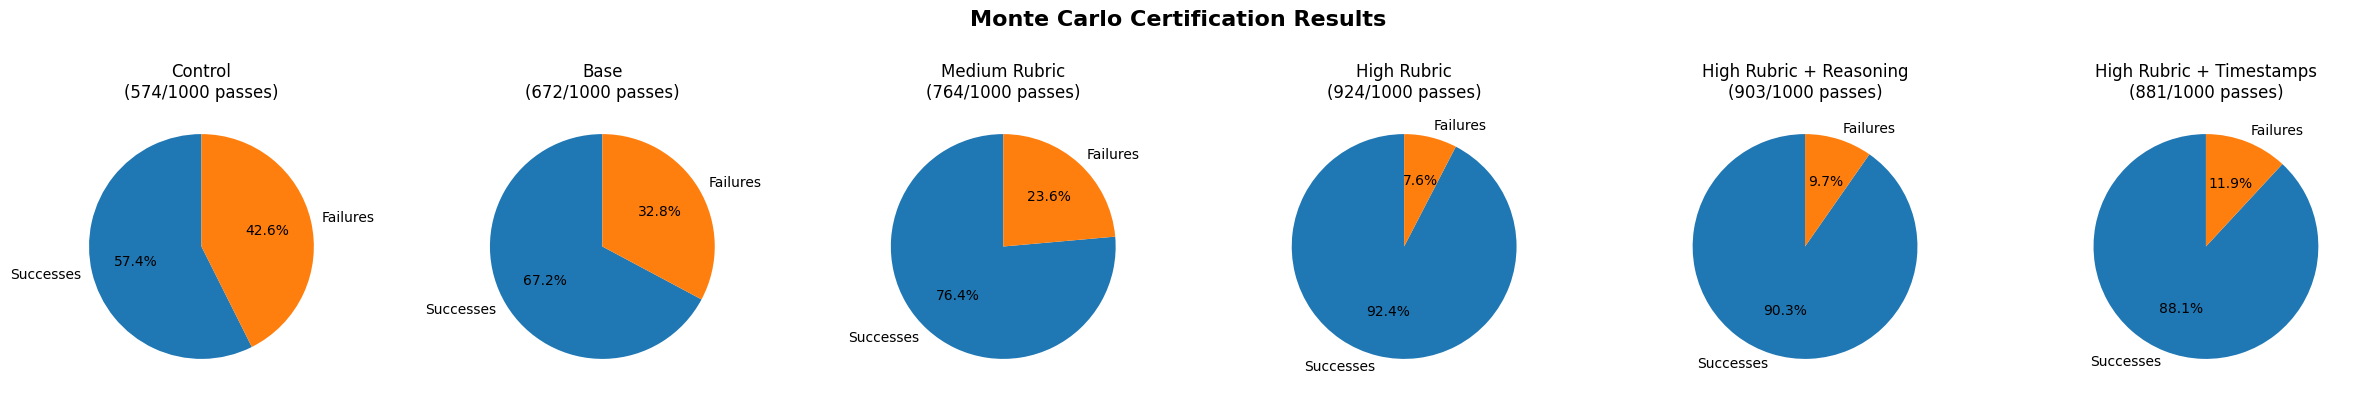


📊 Creating segment-pass dashboard …


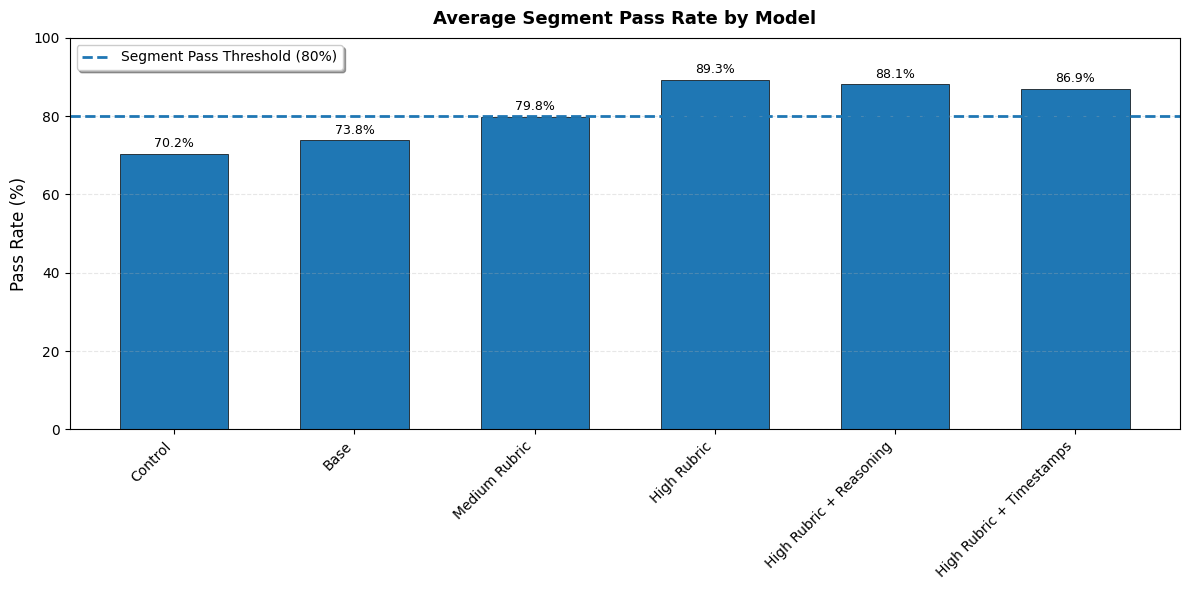


🎉 All reliability analyses and visualisations completed successfully!

📁 Outputs saved to: model_visualizations
  • Autonomy_reliability.png
  • Checks_for_understanding_reliability.png
  • Critical_Thinking_reliability.png
  • Feedback_reliability.png
  • Lesson_Facilitation_reliability.png
  • Perseverance_reliability.png
  • Positive_Behavioral_Expectations_reliability.png
  • Social__Collaborative_Skills_reliability.png
  • Supportive_Learning_Environment_reliability.png
  • Time_on_Learning_reliability.png
  • detailed_metrics_table.png
  • exam_pass_rate.png
  • model_performance_metrics.csv
  • model_progression_chart.png
  • monte_carlo_pie_charts.png
  • reliability_exam_dashboard.png
  • reliability_exam_summary.txt
  • segment_pass_dashboard.png


In [21]:
# Reliability Exam Execution  ← ENTIRE CELL REPLACED
import os
import glob
import pandas as pd

# 1. Gather AI evaluation rows
ai_df_list = []
for fp in glob.glob(os.path.join(EVALS_DIR, '*_evaluations.csv')):
    df = pd.read_csv(fp, dtype=str)
    df['model_name'] = os.path.basename(fp).replace('_evaluations.csv', '')
    ai_df_list.append(df)
ai_df_all = pd.concat(ai_df_list, ignore_index=True)

# 2. Load human evaluations
human_df_all = load_human_evaluations(TRANSCRIPTS_PATH, FRAMEWORK_PATH)

# 3. Identify models
models = ai_df_all['model_name'].unique().tolist()

# 4. Run exams
random_results = run_random_exam(
    models, ai_df_all, human_df_all,
    attempts=2, set_size=3, seed=42, n_simulations=1000
)
avg_results = run_average_exam(models, ai_df_all, human_df_all)

# 5. Monte-Carlo pie charts
print("\n📊 Creating Monte-Carlo certification pie charts …")
pie_path = os.path.join(VIZ_DIR, 'monte_carlo_pie_charts.png')
fig_pie = create_monte_carlo_pie_charts(random_results, save_path=pie_path)

# 6. Segment-level dashboard
print("\n📊 Creating segment-pass dashboard …")
dash_path = os.path.join(VIZ_DIR, 'segment_pass_dashboard.png')
fig_dash = create_exam_performance_dashboard(avg_results, save_path=dash_path)

print("\n🎉 All reliability analyses and visualisations completed successfully!")
print(f"\n📁 Outputs saved to: {VIZ_DIR}")
for fn in sorted(os.listdir(VIZ_DIR)):
    print(f"  • {fn}")


## 10. Summary and Interpretation

Generate a comprehensive summary of the reliability exam results and provide interpretation guidance.

In [22]:
def generate_comprehensive_summary(avg_results, random_results):
    """
    Generate a comprehensive text summary of the reliability exam results.
    """
    models = list(avg_results.keys())
    n_models = len(models)

    # Overall segment pass rates (%)
    pass_rates = [avg_results[model]['pass_rate'] * 100 for model in models]
    certified_count = sum(random_results[model]['certified'] for model in models)

    # Best and worst
    best_idx = np.argmax(pass_rates)
    worst_idx = np.argmin(pass_rates)
    avg_pass = np.mean(pass_rates)

    lines = []
    lines.append("🔍 RELIABILITY EXAM ANALYSIS SUMMARY")
    lines.append("=====================================")
    lines.append(f"\n📊 MODELS EVALUATED: {n_models}")
    lines.append(f"Models: {', '.join(models)}")
    lines.append(f"\n🎯 CERTIFICATION RESULTS:")
    lines.append(f"- Models Certified: {certified_count} of {n_models} "
                 f"({certified_count/n_models*100:.1f}%)")
    lines.append(f"- Models Failed: {n_models-certified_count} of {n_models} "
                 f"({(n_models-certified_count)/n_models*100:.1f}%)")
    lines.append(f"\n📈 PERFORMANCE BENCHMARKS:")
    lines.append(f"- Average Segment Pass Rate: {avg_pass:.1f}%")
    lines.append(f"- Best Model: {models[best_idx]} ({pass_rates[best_idx]:.1f}%)")
    lines.append(f"- Worst Model: {models[worst_idx]} ({pass_rates[worst_idx]:.1f}%)")

    # Recommendations or insights could be added here...

    return {
        'total_models': n_models,
        'certified_models': certified_count,
        'avg_pass_rate': avg_pass,
        'best_model': models[best_idx],
        'worst_model': models[worst_idx],
        'lines': lines
    }

# Generate comprehensive summary
summary_stats = generate_comprehensive_summary(avg_results, random_results)

# Save summary to file
summary_path = os.path.join(VIZ_DIR, 'reliability_exam_summary.txt')
with open(summary_path, 'w') as f:
    # Capture the printed output (simplified version)
    f.write(f"Reliability Exam Summary\n")
    for line in summary_stats['lines']:
        f.write(line + "\n")
    f.write(f"======================\n\n")
    f.write(f"Models Evaluated: {summary_stats['total_models']}\n")
    f.write(f"Models Certified: {summary_stats['certified_models']}\n")

print(f"\nReport generated successfully! ✅")


Report generated successfully! ✅
